# Description

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('agg')
from sklearn.cluster import KMeans
from scipy import stats
import numpy as np
import csv
import os
import shutil
import multiprocess
import warnings
import gc
import psutil
warnings.filterwarnings('ignore')

# Parameters

In [2]:
assembly = "./data/final.p_ctg.fasta"
coverage_per_contig = "./data/heliopora_coerulea_hifi_2_p_assembly.coverage"
coverage_per_base = "./data/heliopora_coerulea_hifi_2_p_assembly.depth"
n_cores = 2
out_dir = "out_dir/"
min_contig_size = 100000
chunk_size = 10000
visualize_gc = False
visualize_coverage = False
visualize_histogram = True
threshold_pct = 50
visualize_blob = True
plot_min_length = 100000
n_clusters = 2
len_to_blast = 1000
space_to_blast = 10000

# Create outdirs

In [3]:
cluster_info = out_dir + "cluster_info/"
coverage_output = out_dir + "Coverage_output/"
GC_visual_output = out_dir + "GC_visual_output/"
if not os.path.exists(cluster_info):
            os.makedirs(cluster_info)
if not os.path.exists(coverage_output):
            os.makedirs(coverage_output)
if not os.path.exists(GC_visual_output):
            os.makedirs(GC_visual_output)
cluster_info = ''
coverage_output = ''
GC_visual_output = ''

# Naive GC content for each content

In [4]:
def get_gc_content(fasta_file):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to their GC content
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    #remove if current_seq y min_contig_size
                    if len(current_seq) > min_contig_size:
                        gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
                        
                # Start the new contig
                current_id = line.strip()[1:].split("/")[3]
                current_seq = ""
            else:
                current_seq += line.strip()
    
    # Calculate GC content for the final contig
    gc_content[current_id] = (current_seq.count("G") + current_seq.count("C")) / len(current_seq)
    
    return gc_content

In [5]:
naive_gc = get_gc_content(assembly)
#print(naive_gc)
print(len(naive_gc))

670


# GC content for each contig by averaging in given chunk sizes

In [6]:
def get_gc_content_chunks(fasta_file, chunk_size):
    """
    Reads in a FASTA file and returns a dictionary mapping contig IDs to a list of gc content per chunk size
    """
    gc_content = {}
    current_id = None
    current_seq = ""
    chunks = []
    
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                # If this is a new contig, calculate the GC content for the previous one (if there was one)
                if current_id is not None:
                    #remove if current_seq < min_contig_size
                    if len(current_seq) > min_contig_size:  
                        i = 0
                        while i < len(current_seq):
                            # check for last chunk
                            if (i + chunk_size) > len(current_seq):
                                end = len(current_seq)
                            else:
                                end = i + chunk_size
                            sub = current_seq[i:end]
                            gc = round(((sub.count("G") + sub.count("C")) / len(sub)),2)
                            chunks.append(gc)
                            i = end
                        # add to dictionary in form {current_id : [array of GC content of given chunk size]}
                        gc_content[current_id] = [chunks, len(current_seq)]

                # Start the new contig
                current_id = line.strip()[1:].split("/")[3]
                current_seq = ""
                chunks = []
                
            else:
                current_seq += line.strip()
                
        # calculate GC content for the last contig
        if current_id is not None:
            i = 0
            while i < len(current_seq):
                # check for last chunk
                if (i + chunk_size) > len(current_seq):
                    end = len(current_seq)
                else:
                    end = i + chunk_size
                sub = current_seq[i:end]
                gc = round(((sub.count("G") + sub.count("C")) / len(sub)), 2)
                chunks.append(gc)
                i = end
            # add to dictionary in form {current_id : [array of GC content of given chunk size, length]}
            gc_content[current_id] = [chunks, len(current_seq)]
        
    return gc_content

In [7]:
chunks = get_gc_content_chunks(assembly, chunk_size)
gc_trimmed_mean = {}
#Get the trimmed mean from chunks
for entry in chunks:
    length = chunks.get(entry)[1]
    avg_cov = chunks.get(entry)[0]
    gc_trimmed_mean[entry] = [stats.trim_mean(avg_cov, 0.05), length]
print(len(gc_trimmed_mean))

670


# Visualize GC content 

In [8]:
if visualize_gc:

    save_dir = out_dir + "/GC_visual_output"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    def process_gc_plot(chunk):
        id = chunk
        
        # added to resume if crashes for whatever reason
        save_path = os.path.join(save_dir, "GC_content_" + str(id) + ".png")
        
        # Skip if the plot already exists
        if not os.path.exists(save_path):
            gc_content = np.array(chunks.get(chunk)[0])

            # create a bar plot
            fig, ax = plt.subplots()
            mean_gc = np.mean(gc_content)
            colors = ['red' if abs(gc - mean_gc) / mean_gc * 100 >= threshold_pct else 'blue' for gc in gc_content]
            plt.bar(range(len(gc_content)), gc_content, color=colors)
            ax.axhline(y=gc_trimmed_mean[id][0], color='black')
            plt.title("Contig: " + str(id))
            plt.xlabel('index of Chunk of size: ' + str(chunk_size))
            plt.ylabel('GC content')
            #save the plot
            plt.savefig(save_path)
            plt.close()
        else:
            print(f'Skipping {id} (already exists)')

    if __name__ == '__main__':
        with multiprocess.Pool(processes=n_cores) as pool:
            print('Starting Visualize GC content')
            pool.map(process_gc_plot, chunks.keys())
            print('Finished Visualize GC content')

else:
    print("GC visualization is turned off.")

GC visualization is turned off.


# Naive coverage

In [9]:
def get_coverage_per_contig(coverage_file):
    naive_coverage = {}

    with open(coverage_file, "r") as f:
        next(f)
        for line in f:
            # Split line into columns
            columns = line.strip().split("\t")

            #only add if length > min_contig_size
            if (int(columns[2]) - int(columns[1])) > min_contig_size:
                # Use the first column as key and the sixth column as value
                key = columns[0].split("/")[3]
                value = columns[6]
                length = int(columns[2]) - int(columns[1])

                # Add key-value pair to dictionary
                naive_coverage[key] = [float(value), length]
            
    f.close()
    return naive_coverage

In [10]:
naive_coverage = get_coverage_per_contig(coverage_per_contig)
print(len(naive_coverage))

669


# Chunk averaged Coverage

In [11]:
def get_coverage_per_contig_by_chunks(depth_file, chunk_size):
    save_dir = out_dir + "Coverage_output/"
    
    # Define a dictionary to store the coverage data for each ID
    id_data = {}

    # Read in the TSV file
    with open(depth_file, 'r') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')

        # Iterate over each row in the file
        for i, row in enumerate(reader):
            if i % 100000000 == 0:
                print(f'reading in line {i}')
            # Extract the ID, index, and coverage from the row
            id = row[0].split("/")[3]
            index = int(row[1])
            coverage = float(row[2])

            # Check if this is the first row for this ID
            if id not in id_data:
                id_data[id] = []

            # Find the window index for this row
            window_index = index // chunk_size

            # Check if there is already coverage data for this window
            if len(id_data[id]) <= window_index:
                # Add a new entry for this window
                id_data[id].append({'window_sum': coverage, 'window_count': 1})
            else:
                # Add the coverage to the existing window data
                id_data[id][window_index]['window_sum'] += coverage
                id_data[id][window_index]['window_count'] += 1            
                
          
    # Write the output to a file
    with open(save_dir + "chunked_windows_coverage.tsv", 'w') as outfile:
        outfile.write("id\tindex\taverage_coverage\n")
        for id, windows in id_data.items():
            #check total length > min_contig_size
            total_len = 0
            for i, window in enumerate(windows):
                total_len += window['window_count']
                if total_len > min_contig_size:
                    for i, window in enumerate(windows):
                        if window['window_count'] > 0:
                            avg_coverage = round((window['window_sum'] / window['window_count']), 2)
                            outfile.write(f"{id}\t{i}\t{avg_coverage}\n")
                        
        outfile.close()
    
    #now get the average coverage for each id
    # Open the input file
    with open(save_dir + "chunked_windows_coverage.tsv", "r") as f:
        next(f)
        # Create a dictionary to store the total coverage and highest index for each id
        id_coverage = {}
        # Read through each line in the file
        for line in f:
            # Split the line into three columns
            id, index, coverage = line.strip().split("\t")
            # Convert the coverage to float
            index = float(index)
            coverage = float(coverage)
            # If the id is not in the dictionary yet, add it with a coverage of 0 and index of -1
            if id not in id_coverage:
                id_coverage[id] = {"coverage": 0, "max_index": -1}
            # Add the coverage to the total for this id
            id_coverage[id]["coverage"] += coverage
            # Update the max index for this id if the current index is higher
            if index > id_coverage[id]["max_index"]:
                id_coverage[id]["max_index"] = index
    f.close()
    
    #make list of coverages, then take trimmed mean of that list
    coverage_trimmed_mean = {}
    for entry in id_data:
        coverages = []
        for chunk in id_data.get(entry):
            window_sum = float(chunk.get('window_sum'))
            window_count = float(chunk.get('window_count'))
            coverage = round((window_sum / window_count), 2)
            coverages.append(coverage)
        
        coverage_trimmed_mean[entry] = round(stats.trim_mean(coverages, 0.05), 2)
        
    # Open the output file
    with open(save_dir + "chunked_coverage.tsv", "w") as f:
        # Write the header row
        f.write("id\taverage_coverage\n")
        # Loop through the ids in the dictionary
        for id in coverage_trimmed_mean:
            average_coverage = coverage_trimmed_mean[id]
            f.write("{}\t{}\n".format(id, average_coverage))
    f.close()

    return id_data

In [12]:
chunks_coverage = get_coverage_per_contig_by_chunks(coverage_per_base, chunk_size)
len(chunks_coverage)

reading in line 0
reading in line 100000000
reading in line 200000000
reading in line 300000000
reading in line 400000000
reading in line 500000000
reading in line 600000000


3348

# Visualize Coverage

In [13]:
#windows
save_dir = out_dir + "Coverage_output/"
data = pd.read_csv(save_dir + "/chunked_windows_coverage.tsv", dtype={'id': 'object'}, sep = "\t")
trimmed_mean = pd.read_csv(save_dir + "/chunked_coverage.tsv", dtype={'id': 'object'}, sep = "\t")

# Convert data to pandas dataframe
df = pd.DataFrame(data)
mean = pd.DataFrame(trimmed_mean)
# Get a list of unique ids
unique_ids = df['id'].unique()
print('length of unique ids ', len(unique_ids))

memory_info = psutil.Process().memory_info()
print(f"Memory used: {memory_info.rss / (1024 ** 2):.2f} MB")

if visualize_coverage:
    print('Starting Visualize Coverage')
    fig, ax = plt.subplots()
    plt.xlabel('Index of chunk size ' + str(chunk_size))
    plt.ylabel('Average coverage')

    for id in unique_ids:
        if id == '000000' or id == '000001':
            print('Need more RAM')
            continue
        print(id)
        memory_info = psutil.Process().memory_info()
        print(f"In loop Memory used: {memory_info.rss / (1024 ** 2):.2f} MB")
        
        # added to resume if crashes for whatever reason
        save_path = os.path.join(save_dir, "Coverage_" + str(id) + ".png")
        
        # Skip if the plot already exists
        if os.path.exists(save_path):
            print(f'Skipping {id} (already exists)')
            continue
            
        print(f'start {id}')
        # Filter the dataframe to get only the rows for this id
        search_str = f"id == '{id}'"
        #print(search_str)
        df_id = df.query(search_str)
        trimmed_mean_coverage = float(mean.loc[mean['id'] == id, 'average_coverage'])
        ax.axhline(y=trimmed_mean_coverage, color='black')
        # filtered colors
        colors = ['red' if abs(coverage - trimmed_mean_coverage) / trimmed_mean_coverage * 100 >= threshold_pct else 'blue' for coverage in df_id['average_coverage']]
        plt.bar(df_id['index'], df_id['average_coverage'], label=f"id={id}", color=colors)
        plt.savefig(save_path)
        plt.clf()
        gc.collect()
        
    print('Finished Visualize Coverage')

else :
    print("Coverage visualization is turned off.")

length of unique ids  669
Memory used: 962.73 MB
Coverage visualization is turned off.


# Blob Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


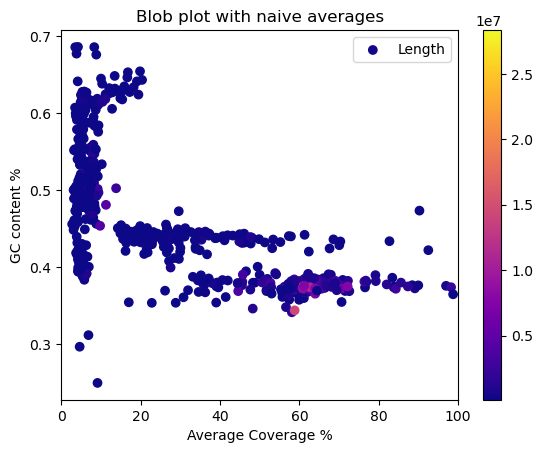

In [14]:
#plot gc content (x) vs coverage (y)
if visualize_blob:

    data = [{'id': k, 'gc_content': v} for k, v in naive_gc.items()]
    data2 = [{'id': k, 'average_coverage': v[0], 'length': v[1]} for k, v in naive_coverage.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    df2 = pd.DataFrame(data2)
    naive_df = pd.merge(df1, df2, on = 'id')
    naive_df = naive_df[naive_df['length'] >= plot_min_length]
    #print(naive_df)

    fig, ax = plt.subplots()
    ax.set_xlim([0, 100])
    cmap = plt.matplotlib.colormaps.get_cmap('plasma')

    sc = plt.scatter(naive_df['average_coverage'], naive_df['gc_content'],  c = naive_df['length'], cmap = cmap)
    cbar = plt.colorbar(sc)
    # Add labels and legend
    plt.xlabel('Average Coverage %')
    plt.ylabel('GC content %')
    plt.title('Blob plot with naive averages')
    plt.legend(loc="upper right")
    ax.legend([sc], ['Length'], loc="upper right")
    
    # save the plot
    save_path = os.path.join(out_dir, "Blob_naive.png")
    plt.savefig(save_path)
    plt.show()

else :
    print("Visualize Naive Blob is turned off.")

# Visualize trimmed 

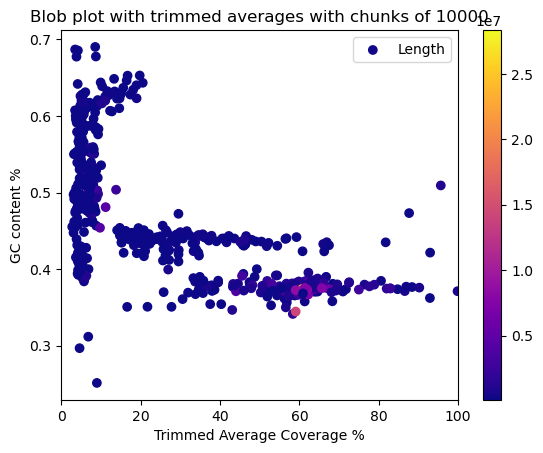

In [15]:
if visualize_blob:

    data = [{'id': k, 'gc_content': v[0], 'length' : v[1]} for k, v in gc_trimmed_mean.items()]
    # Convert the list of dictionaries to dataframes
    df1 = pd.DataFrame(data)
    trimmed_df = pd.merge(df1, trimmed_mean, on = 'id')
    trimmed_df = trimmed_df[trimmed_df['length'] >= plot_min_length]
    #print(trimmed_df) 

    fig, ax = plt.subplots()
    ax.set_xlim([0, 100])
    cmap = plt.matplotlib.colormaps.get_cmap('plasma')

    #labels = list(trimmed_df['id'])
    sc1 = plt.scatter(trimmed_df['average_coverage'], trimmed_df['gc_content'], c = trimmed_df['length'], cmap = cmap)
    cbar = plt.colorbar(sc1)
    # Add labels and legend
    plt.xlabel('Trimmed Average Coverage %')
    plt.ylabel('GC content %')
    plt.title('Blob plot with trimmed averages with chunks of ' + str(chunk_size))
    ax.legend([sc1], ['Length'], loc="upper right")

    # save the plot
    save_path = os.path.join(out_dir, "Blob.png")
    plt.savefig(save_path)

else :
    print("Visualize Trimmed Blob is turned off.")

# Histogram of contig lengths

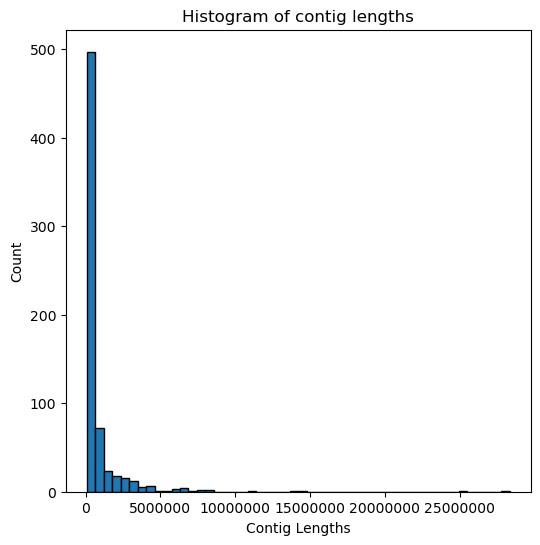

In [16]:
#Histogram of all contig lengths

if visualize_histogram:
    data = trimmed_df["length"]
    #print(data)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(data, bins=50, edgecolor='black')
    ax.ticklabel_format(style='plain', axis='x')
    
    plt.xlabel('Contig Lengths')
    plt.ylabel('Count')
    plt.title('Histogram of contig lengths')
    
    # save the plot
    save_path = os.path.join(out_dir, "Histogram_of_lengths.png")
    plt.savefig(save_path)

    # Show the plot
    plt.show()

# K-Means

Using this plot you will need to select which cluster is the main cluster for the next step
total length of cluster 0 : 119741358
Using this plot you will need to select which cluster is the main cluster for the next step
total length of cluster 1 : 441283783


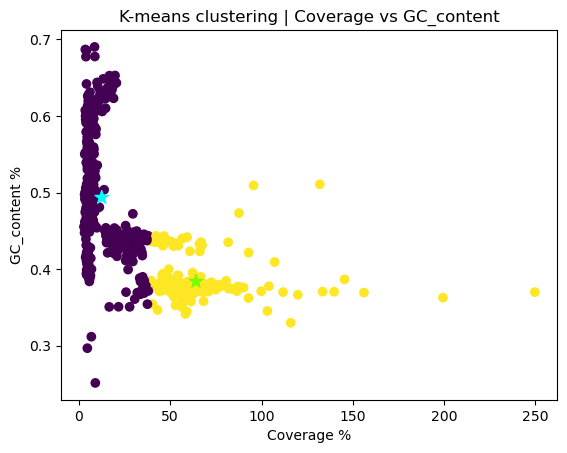

In [17]:
#kmeans to get clusters in blob plots
np.random.seed(42)

coverage = trimmed_df['average_coverage']
gc_content = trimmed_df['gc_content']
ids = trimmed_df['id'].values

#make a feature matrix
X = np.column_stack((coverage, gc_content))

#kmeans clusters = n_clusters
kmeans = KMeans(n_clusters, random_state = 42, n_init='auto').fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#create a dictionary for each cluster
cluster_points = {i: [] for i in range(len(centroids))}

#add the ids to each cluster in the dictionary
for i, label in enumerate(labels):
    cluster_points[label].append(ids[i])

#look up each point in dataframe to get length
for cluster in cluster_points:
    total_cluster_length = 0
    
    print('Using this plot you will need to select which cluster is the main cluster for the next step')
    #for each id for each cluster into a seperate file
    with open(out_dir + 'cluster_info/cluster_' + str(cluster) + '.txt', 'w') as out:
        for i in cluster_points[cluster]:
            #write ids into output
            out.write(i + '\n')
            
            #get length and total length
            length = trimmed_df.loc[trimmed_df['id'] == i, 'length'].iloc[0]
            total_cluster_length += length
    print('total length of cluster ' + str(cluster) + ' : ' + str(total_cluster_length))
    
colors = ['aqua', 'lawngreen']
#plotting
plt.scatter(X[:,0], X[:,1], c = labels)
plt.scatter(centroids[:,0], centroids[:,1], marker = '*', s = 100, c = colors)
plt.xlabel('Coverage %')
plt.ylabel('GC_content %')
plt.title('K-means clustering | Coverage vs GC_content')

# save the plot
save_path = os.path.join(out_dir, "Kmeans_clustering.png")
plt.savefig(save_path)

plt.show()

# Making Fasta with ids in target cluster

In [22]:
#Set target cluster 
target_cluster = 1
if not os.path.exists(out_dir + 'cluster_info/cluster_' + str(target_cluster)+ '/split_contigs/'):
            os.makedirs(out_dir + 'cluster_info/cluster_' + str(target_cluster)+ '/split_contigs/')

In [19]:
#for each id in cluster 0 get the sequence and write into a fasta file
    #we already have a fasta file with these ids, we just need to extract only the ones we are interested in
with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.fasta', 'w') as fasta:
    with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.txt', 'r') as cluster:
        for line in cluster:
            header = line.strip()
            #write header
            fasta.write('>' + header + '\n')
            #before next header write line for sequence
            #search for the header line in assembly which includes header
            with open(assembly, 'r') as big:
                found = False
                for line in big:
                    if found:
                        sequence = line.strip()
                        found = False
                        break
                    if header in line:
                        found = True
            big.close()
            fasta.write(str(sequence) + '\n')
    
    cluster.close()
fasta.close()

In [24]:
#Split each entry in fasta file, i.e every 10k take 1k sample
#for each entry in fasta file, if length > 10000 then take small chunk every 10000bp
with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '.fasta', 'r') as fasta:
    for line in fasta:
        if '>' in line:
            #write in split_contigs
            #print(line)
            line = ''.join(line.split())
            contig_name = str(line.replace('>', ''))
        else:
            with open(out_dir + 'cluster_info/cluster_' + str(target_cluster) + '/split_contigs/' + contig_name + '.fasta', 'w') as contig_file:
                #split into substrings of len_to_blast every space_to_blast
                length = len(line)
                #print(length)
                if length > (space_to_blast + len_to_blast):
                    #loop
                    pos = 0
                    while pos < length:
                        start = pos
                        end = pos + len_to_blast
                        #header = startpos endpos
                        #sequence = sequence
                        seq = (line[start:end] + '\n')
                        header = ('>' + str(start) + ' : ' + str(end) + '\n')
                        pos += space_to_blast + len_to_blast
                        contig_file.write(header)
                        contig_file.write(seq)
                
            contig_file.close()
            
fasta.close()

# Run Blast, then Blast_results notebook to compare Blast filtering with K-means

## Blob plot with Fasta

336
         id  gc_content  length  average_coverage
0    000409    0.436857  360235             22.45
1    000412    0.369412  359644            156.09
2    000414    0.433226  328050             20.07
3    000417    0.384412  354818             64.86
4    000419    0.477941  352581              7.72
..      ...         ...     ...               ...
664  001104    0.440000  100662             21.41
665  001105    0.492727  100585              3.62
666  001106    0.429091  100421              4.83
667  001107    0.630909  100291              6.03
668  001127    0.550000  100461              3.16

[669 rows x 4 columns]
         id  gc_content  length  average_coverage  in_fasta
0    000409    0.436857  360235             22.45      True
1    000412    0.369412  359644            156.09      True
2    000414    0.433226  328050             20.07      True
3    000417    0.384412  354818             64.86     False
4    000419    0.477941  352581              7.72     False
..      ... 

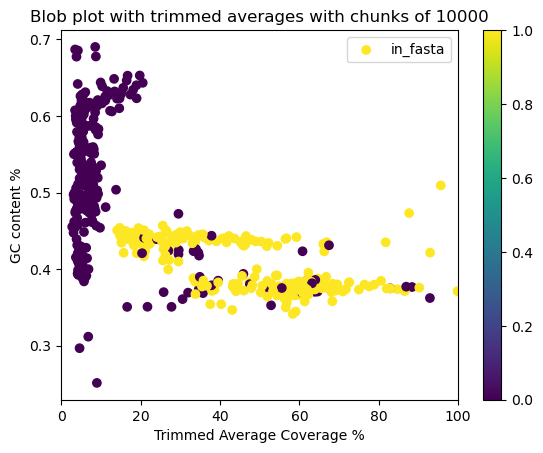

In [26]:
#trimmed_df['id'] = int(trimmed_df['id'])
with open('out_dir/cluster_info/needed.txt','r') as keys:
    tot = []
    for line in keys:
        k = line.strip('\n')
        tot.append(k)
print(len(tot))
    
    
#plot blob again and color contigs with keys as labels

data = [{'id': k, 'gc_content': v[0], 'length' : v[1]} for k, v in gc_trimmed_mean.items()]
# Convert the list of dictionaries to dataframes
df1 = pd.DataFrame(data)
trimmed_df = pd.merge(df1, trimmed_mean, on = 'id')
trimmed_df = trimmed_df[trimmed_df['length'] >= plot_min_length]
print(trimmed_df) 

#add column if contained in keys
trimmed_df['in_fasta'] = trimmed_df['id'].isin(tot)
print(trimmed_df)
print('in fasta contigs found in this set ' + str(trimmed_df.in_fasta.sum()))

fig, ax = plt.subplots()
ax.set_xlim([0, 100])

#labels = list(trimmed_df['id'])
sc1 = plt.scatter(trimmed_df['average_coverage'], trimmed_df['gc_content'], c = trimmed_df['in_fasta'])
cbar = plt.colorbar(sc1)
# Add labels and legend
plt.xlabel('Trimmed Average Coverage %')
plt.ylabel('GC content %')
plt.title('Blob plot with trimmed averages with chunks of ' + str(chunk_size))
ax.legend([sc1], ['in_fasta'], loc="upper right")

# save the plot
save_path = os.path.join(out_dir, "Fasta_Blob.png")
plt.savefig(save_path)

# Show the plot
plt.show()

## Plot histogram of lengths of this subset

         id  gc_content    length  average_coverage  in_fasta
514  000000    0.374040  28339776             61.31      True
515  000001    0.374186  25161013             60.70      True
516  000002    0.344697  14298951             59.05      True
517  000003    0.371818  13672165             60.59      True
519  000005    0.372806  10947282             60.71      True
..      ...         ...       ...               ...       ...
655  001087    0.440000    102180             15.34      True
658  001093    0.444545    101455             16.67      True
173  000724    0.441818    101261             59.24      True
660  001097    0.434545    101120             15.19      True
664  001104    0.440000    100662             21.41      True

[336 rows x 5 columns]


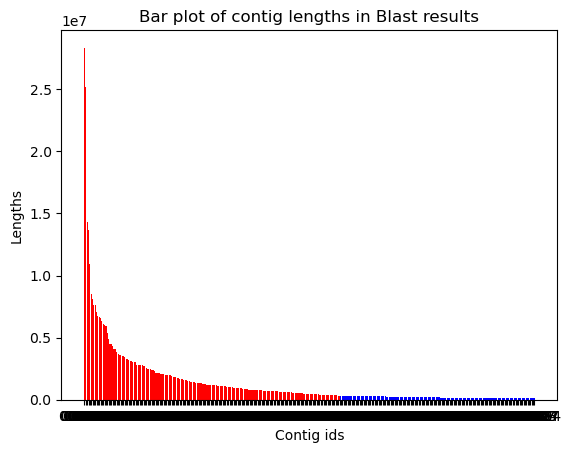

In [27]:
#Bar plot of lengths of in fasta in trimmed_df
data = trimmed_df[trimmed_df["in_fasta"] == True]
data = data.sort_values(by=['length'], ascending=False)
print(data)
#x is ids
x = data['id']
#y is length of ids
y = data['length']

#color contigs up to total length of genome size
current = 0
length = 430000000
#add lengths together till greater than length
for i, l in enumerate(y):
    current += l
    if current > length:
        #print(i)
        cutoff = l
        break
        
mask1 = y >= cutoff
mask2 = y < cutoff

plt.bar(x[mask1], y[mask1], color = 'red')
plt.bar(x[mask2], y[mask2], color = 'blue')
#plt.bar(x, y)

plt.xlabel('Contig ids')
plt.ylabel('Lengths')
plt.title('Bar plot of contig lengths in Blast results')
# save the plot
save_path = os.path.join(out_dir, "Histogram_of_lengths_of_subset.png")
plt.savefig(save_path)

# Show the plot
plt.show()

In [28]:
#save selected contigs
subset = data.head(190)
print(subset)
subset.to_csv('./out_dir/blast_subset.csv',index=False)

         id  gc_content    length  average_coverage  in_fasta
514  000000    0.374040  28339776             61.31      True
515  000001    0.374186  25161013             60.70      True
516  000002    0.344697  14298951             59.05      True
517  000003    0.371818  13672165             60.59      True
519  000005    0.372806  10947282             60.71      True
..      ...         ...       ...               ...       ...
0    000409    0.436857    360235             22.45      True
1    000412    0.369412    359644            156.09      True
5    000424    0.440303    347021             56.72      True
6    000425    0.371818    345480             50.63      True
12   000434    0.432812    333038             65.98      True

[190 rows x 5 columns]


In [29]:
#for each id in blast_subset add that contig to a fasta file
ids = []
with open('./out_dir/blast_subset.csv','r') as csv_file:
    reader = csv.reader(csv_file)
    next(reader)
    for row in reader:
        ids.append(row[0])
    
output_file = open('ourGenome.fasta', 'a')
with open(assembly, 'r') as fasta_file:
    header = ''
    sequence = ''
    for line in fasta_file:
        if line.startswith('>'):
            #check if id in list
            if any(id in line for id in ids):
                header = line.strip()
        else:
            sequence = line.strip()
            if header and sequence:
                output_file.write(header + '\n')
                output_file.write(sequence + '\n')
                header = ''
                sequence = ''
                
output_file.close()

         id  gc_content  length  average_coverage  in_fasta
0    000409    0.436857  360235             22.45      True
1    000412    0.369412  359644            156.09      True
2    000414    0.433226  328050             20.07      True
3    000417    0.384412  354818             64.86     False
4    000419    0.477941  352581              7.72     False
..      ...         ...     ...               ...       ...
664  001104    0.440000  100662             21.41      True
665  001105    0.492727  100585              3.62     False
666  001106    0.429091  100421              4.83     False
667  001107    0.630909  100291              6.03     False
668  001127    0.550000  100461              3.16     False

[669 rows x 5 columns]
         id  gc_content   length  average_coverage  in_fasta
442  000022    0.480925  4307378             11.15     False
510  000026    0.453995  4075042              9.73     False
403  000034    0.554341  3440720              7.38     False
407  000038 

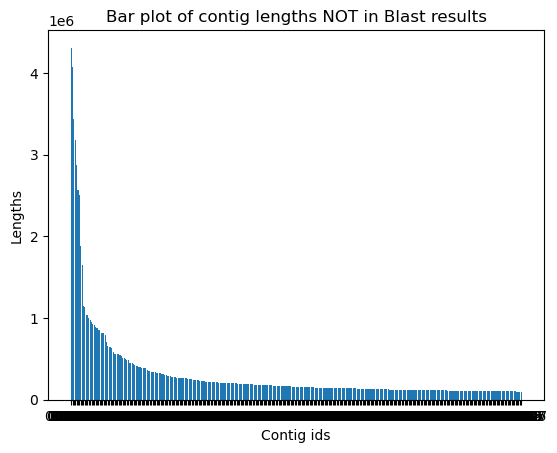

In [30]:
#TODO find lengths of discarded
data = [{'id': k, 'gc_content': v[0], 'length' : v[1]} for k, v in gc_trimmed_mean.items()]
# Convert the list of dictionaries to dataframes
df1 = pd.DataFrame(data)
discarded = pd.merge(df1, trimmed_mean, on = 'id')
discarded = discarded[discarded['length'] >= plot_min_length]
discarded['in_fasta'] = discarded['id'].isin(tot)
print(discarded)

#take only false
data = discarded[discarded["in_fasta"] == False]
data = data.sort_values(by=['length'], ascending=False)
print(data)

#x is ids
x = data['id']
#y is length of ids
y = data['length']
plt.bar(x,y)

plt.xlabel('Contig ids')
plt.ylabel('Lengths')
plt.title('Bar plot of contig lengths NOT in Blast results')
save_path = os.path.join(out_dir, "Histogram_of_lengths_not_in_Blast_results.png")
plt.savefig(save_path)

# Show the plot
plt.show()